In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

In [2]:
df = pd.read_csv("2024NYCMARATHONRESULTS.csv")

# A) Understanding the dataset
<ol>
  <li>See datatypes</li>
  <li>Understand missing values</li>
  <li>Verify basic statistics of each column</li>
</ol>

In [3]:
df.head()

,runnerId,firstName,bib,age,gender,city,countryCode,stateProvince,iaaf,overallPlace,overallTime,pace,genderPlace,ageGradeTime,ageGradePlace,ageGradePercent,racesCount
0,41771195,Abdi,7.0,35,M,Nijmegen,NLD,NaN,NED,1,2:07:39,4:53,1,6:57,1,96.86,4
1,41775746,Evans,3.0,35,M,Kapsabet,KEN,-,KEN,2,2:07:45,4:53,2,7:03,2,96.79,2
2,41766254,Albert,2.0,30,M,Kapkitony,KEN,NaN,KEN,3,2:08:00,4:53,3,8:00,3,96.06,5
3,41763160,Tamirat,1.0,33,M,Addis Ababa,ETH,NaN,ETH,4,2:08:12,4:54,4,8:02,4,96.03,4
4,41757406,Geoffrey,6.0,31,M,Kapchorwa District,KEN,-,KEN,5,2:08:50,4:55,5,8:50,6,95.44,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55524 entries, 0 to 55523
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   runnerId         55524 non-null  int64  
 1   firstName        55524 non-null  object 
 2   bib              55512 non-null  float64
 3   age              55524 non-null  int64  
 4   gender           55512 non-null  object 
 5   city             55462 non-null  object 
 6   countryCode      55512 non-null  object 
 7   stateProvince    55231 non-null  object 
 8   iaaf             55511 non-null  object 
 9   overallPlace     55524 non-null  int64  
 10  overallTime      55524 non-null  object 
 11  pace             55524 non-null  object 
 12  genderPlace      55524 non-null  int64  
 13  ageGradeTime     55524 non-null  object 
 14  ageGradePlace    55524 non-null  int64  
 15  ageGradePercent  55524 non-null  float64
 16  racesCount       55524 non-null  int64  
dtypes: float64(2

In [5]:
df.isna().sum()

runnerId             0
firstName            0
bib                 12
age                  0
gender              12
city                62
countryCode         12
stateProvince      293
iaaf                13
overallPlace         0
overallTime          0
pace                 0
genderPlace          0
ageGradeTime         0
ageGradePlace        0
ageGradePercent      0
racesCount           0
dtype: int64

In [6]:
df.describe()

,runnerId,bib,age,overallPlace,genderPlace,ageGradePlace,ageGradePercent,racesCount
count,5.552400e+04,55512.000000,55524.000000,55524.00000,55524.000000,55524.000000,55524.000000,55524.000000
mean,4.177795e+07,33128.603707,39.893596,27762.50000,13983.581712,13983.453119,52.361798,12.912488
std,1.605918e+04,18932.492867,11.609486,16028.54251,8287.204370,8287.420736,10.988954,30.013987
min,4.175012e+07,1.000000,0.000000,1.00000,1.000000,0.000000,0.000000,1.000000
25%,4.176405e+07,16975.750000,30.000000,13881.75000,6881.750000,6881.750000,44.930000,1.000000
50%,4.177796e+07,32991.500000,39.000000,27762.50000,13822.000000,13822.000000,51.740000,2.000000
75%,4.179186e+07,49419.250000,48.000000,41643.25000,20762.250000,20762.250000,59.030000,12.000000
max,4.180576e+07,67000.000000,88.000000,55524.00000,30696.000000,30696.000000,96.860000,1393.000000


# B) Cleaning & Transforming the data
<ol>
  <li>Remove irrelevant columns</li>
  <li>Remove rows with missing values</li>
  <li>Convert <b>pace</b> and <b>overallTime</b> into a usable format</li>
</ol>

### B.1 Removing irrelevant columns

In [7]:
df = df.drop(columns=['ageGradeTime','bib','iaaf'])

ageGradeTime will not be used in the analysis due to its uneven distribution. Some runners have a value that is in minutes, and some in the tens of hours

bib numbers do not matter to this analysis. runnerId is a unique identifier

iaaf is the three letter country code, and is a duplicate of the countryCode column

### B.2 Removing NA values from important columns

In [8]:
marathon = df.dropna(subset=["gender","countryCode"])

Although we have missing values for city and stateProvince, these are irrelevant since our geographic analysis will pivot on runners from the US, which have complete data.

In [9]:
marathon['pace'][-20:]

55504       23:05
55505       23:16
55506       23:19
55507       23:27
55508       23:37
55509       23:51
55510       23:56
55511    24:07:00
55512    24:17:00
55513    24:43:00
55514    25:01:00
55515    25:42:00
55516    26:02:00
55517    26:05:00
55518    26:05:00
55519    26:06:00
55520    26:39:00
55521    26:48:00
55522    26:50:00
55523    27:00:00
Name: pace, dtype: object

The dataset incorrectly converted paces of 24 minutes and above into an hourly format. We will consider this invalid and remove these instances

### B.3 Fixing and converting datatypes

In [10]:
invalid_times = marathon[(marathon['pace'].str.contains(r'^2[4-9]:', na=False))] # Paces that are above 24 hours
marathon = marathon.drop(invalid_times.index)

In [11]:
marathon['gender'] = marathon['gender'].replace({
    'M': 'Male',
    'W': 'Female',
    'X': 'Non-Binary'
})

In [12]:
# Convert overallTime and pace variables to an Hours, Minutes and, Seconds format
marathon['overallTime'] = pd.to_timedelta(marathon['overallTime'].astype(str))
marathon['pace'] = '00:' + marathon['pace']
marathon['pace'] = pd.to_timedelta(marathon['pace'].astype(str))

# Create age groups
bins = [0, 18, 30, 40, 50, 60, 70, 100]
labels = ['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '>70']
marathon['ageGroup'] = pd.cut(marathon['age'], bins=bins, labels=labels)

# C) Demographic Analysis

### C.1 Gender Distribution

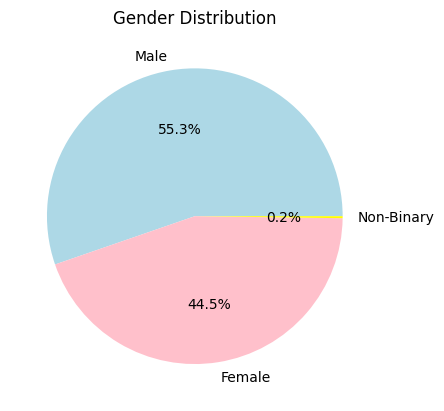

In [13]:
gender_counts = marathon['gender'].value_counts()

plt.pie(gender_counts, labels=gender_counts.index,autopct="%1.1f%%", colors=['lightblue', 'pink', 'yellow'])
plt.title('Gender Distribution')
plt.show()

### C.2 Age Distribution

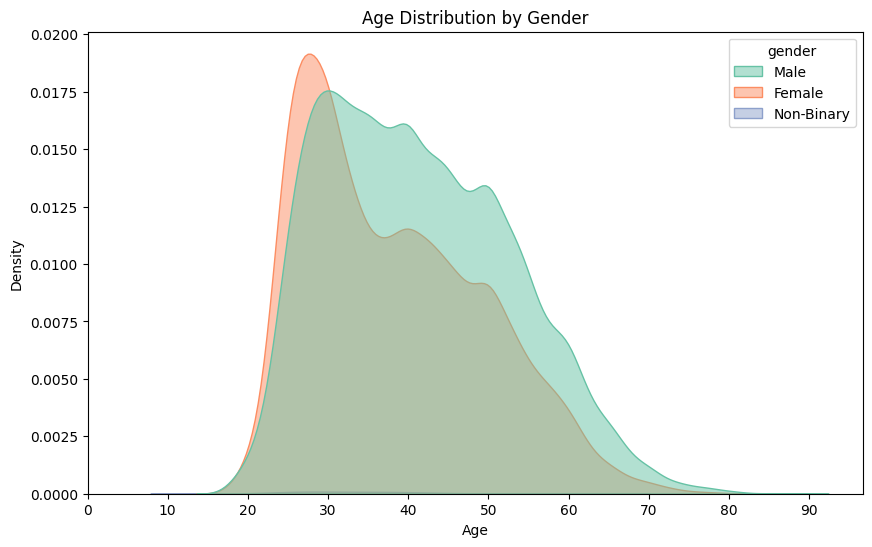

In [33]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=marathon, x='age', hue='gender', fill=True, palette='Set2', alpha=0.5)
plt.title('Age Distribution by Gender')
plt.xticks(range(0,100,10))
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

### C.3 Age Group Distribution

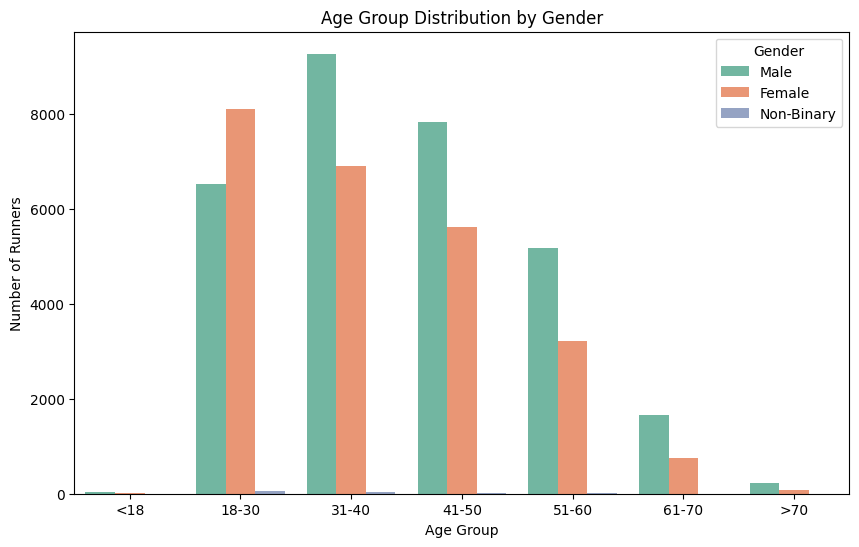

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=marathon, x='ageGroup', hue='gender', palette='Set2')
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Number of Runners')
plt.legend(title='Gender')
plt.show()

### C.4 Runner Home Countries

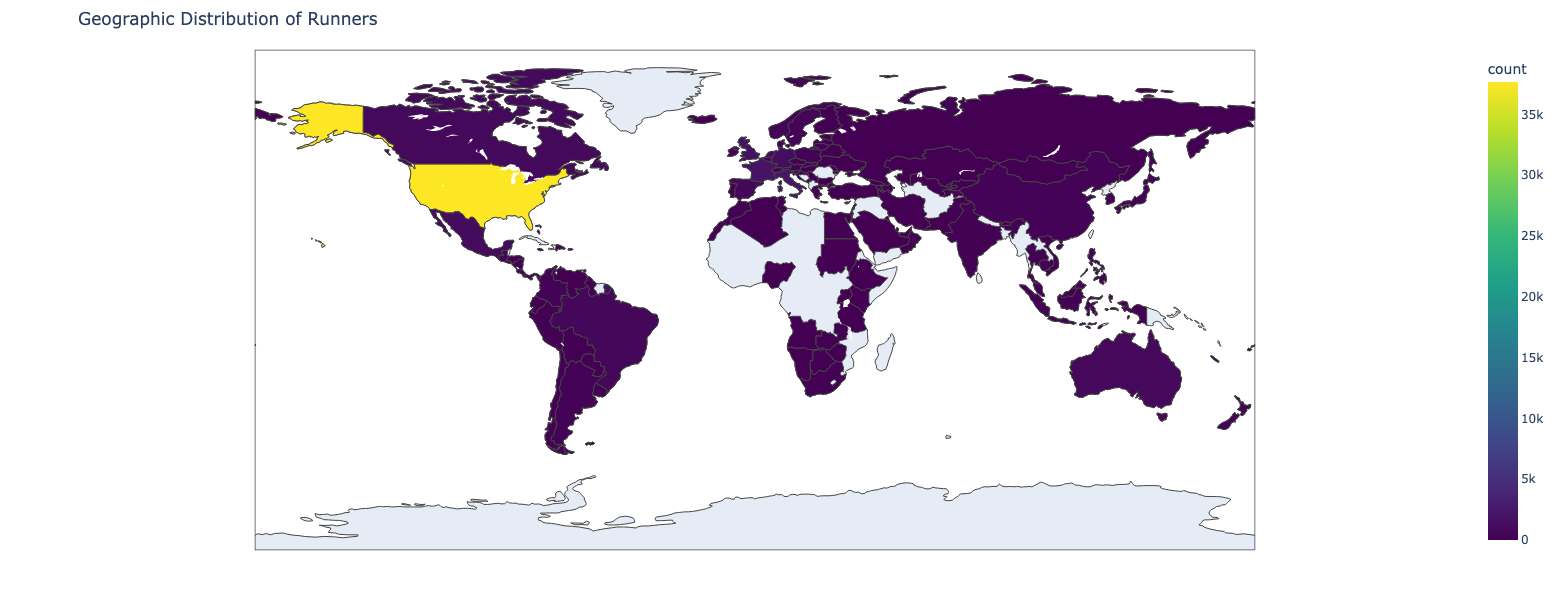

In [40]:
top_countries = df['countryCode'].value_counts().reset_index()
top_countries.columns = ['country', 'count']

fig = px.choropleth(
    top_countries, 
    locations='country', 
    locationmode='ISO-3', 
    color='count',
    title='Geographic Distribution of Runners',
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(margin=dict(l=60, r=60, t=50, b=50), # Set dimensions so map is zoomed into
    width=1000,  
    height=600   
)

fig.show()

### C.5 Geographic Distribution of Runners from the US

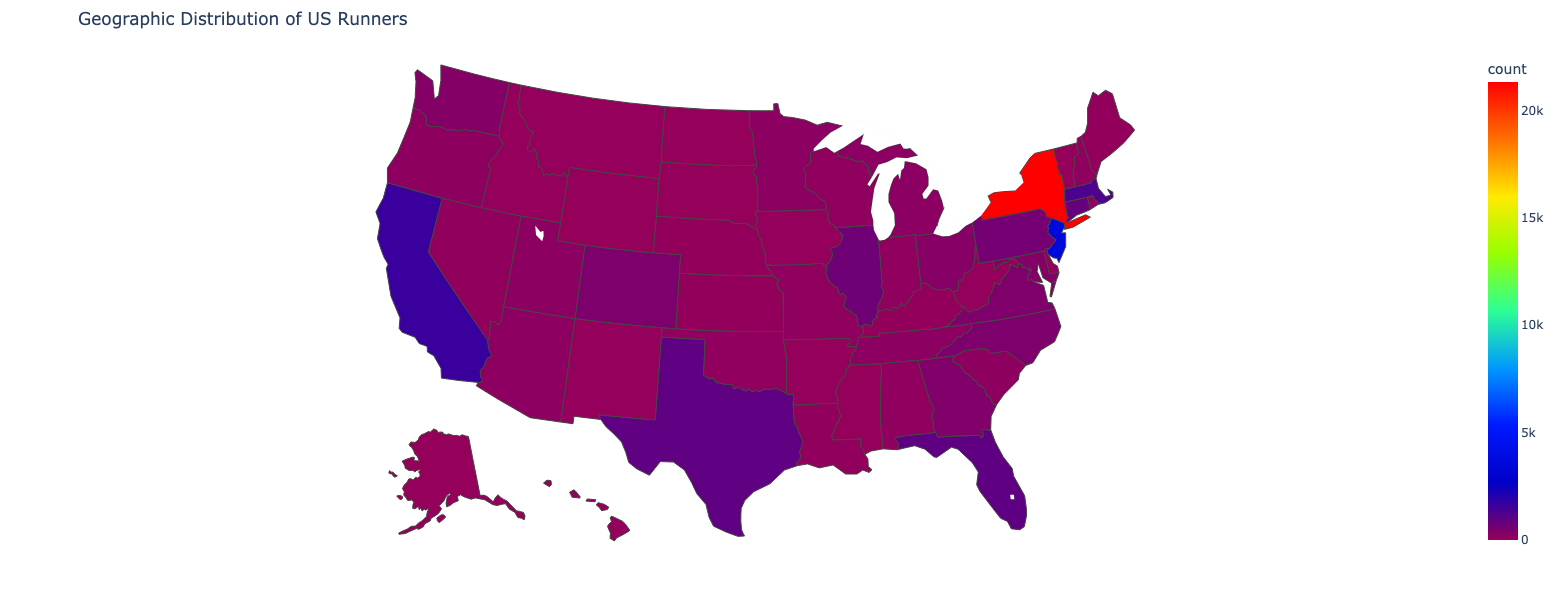

In [63]:
us_marathon = marathon[marathon['countryCode'] == 'USA']

state_counts = us_marathon['stateProvince'].value_counts().reset_index()
state_counts.columns = ['state', 'count']

fig = px.choropleth(
    state_counts,
    locations='state',  # Column with state abbreviations
    locationmode='USA-states',  # Use state abbreviations for US map to ensure our data and data from plotly is the same=
    color='count', 
    color_continuous_scale='Rainbow',  
    scope='usa',  
    title='Geographic Distribution of US Runners'
)


fig.update_layout(margin=dict(l=60, r=60, t=50, b=50),
    width=1000,  # Set the width of the figure
    height=600   # Set the height of the figure
)

fig.show()

# D) Performance